In [1]:
! pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=4def10c3a683fa949d66308b47a2c0fe8b7c2e099a3ee5b15f9fd0e7aeea25f2
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [3]:

def train_test_split(x, y):
    trainX, testX, trainY, testY = \
        model_selection.train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=4487)
    return trainX, trainY, testX, testY


def plot_roc(validY, validProb):
    # ROC AUC
    fpr, tpr, thresholds = metrics.roc_curve(validY, validProb, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print("ROC_AUC :", roc_auc)

    fig = plt.figure()
    fig.patch.set_facecolor('#e8e8f8')
    plt.plot(fpr, tpr, 'k-', lw=2, color='#7777cb')
    plt.title('AUC={:.4f}'.format(roc_auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.gca().set_facecolor('#e8e8f8')

    plt.grid(True)
    plt.show()

In [4]:
import pickle

import pandas as pd

from utils import *
from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from numpy import *
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

random.seed(4487)
with open('/kaggle/input/dm-pkl/data.pkl', 'rb') as file:
    # 使用pickle的load方法从文件反序列化数据
        data_loaded = pickle.load(file)
# data_loaded现在是一个包含x，y，label的字典
x = data_loaded['x']
y = data_loaded['y']
label = data_loaded['label']
trainX, testX, trainY, testY = train_test_split(x, y)

# ASVM detail

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import numpy

from numpy import *
from sklearn import *
from pandas import *
from scipy import stats

# 原始SVAM的重复性过程抽出定义为函数

In [13]:
def SFLA_SVM(x_traincv, y_traincv,x_testcv, y_testcv,kernel,C,gamma=False,degree=False,coef0=False):
    if C < 0:
        C = random.randint(1,5) 
    clf = svm.SVC(C=C, kernel=kernel,gamma=gamma, coef0=coef0, probability=True,random_state=920).fit(x_traincv, y_traincv)
    y_score = clf.predict_proba(x_testcv)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_testcv, y_score, pos_label=1)
    roc_auc = metrics.auc(fpr,tpr)
    
    return roc_auc 

In [14]:
print(- 0.0002/log(0.01))#最小温度
print(- 0.0002/log(0.4))#最大温度
#这里改一下
print((0.0002182713335874583/0.00004342944819032519)**(1/10))  
a = 0.0004342944819032519
for i in range(10):
    a*=1.175
print(a)
print(e**(-0.0001/0.00021785271532936534))
print(random.randint(1,10))

4.342944819032519e-05
0.00021827133358745833
1.1752255889451046
0.0021785271532936534
0.6318989908213715
7


In [15]:
def SFLA_SVM_CV(x_train, y_train,n,kernel,C,gamma=False,degree=False,coef0=False):
    '''
    n: number of splits for k-fold
    
    '''
    KF = KFold(n_splits=n,shuffle=True, random_state=920)
    f = []
    for train_indexcv,test_indexcv in KF.split(x_train):
        x_traincv, x_testcv = x_train.iloc[train_indexcv][:], x_train.iloc[test_indexcv][:]
        y_traincv, y_testcv = y_train.iloc[train_indexcv][:], y_train.iloc[test_indexcv][:]
        fq = SFLA_SVM(x_traincv, y_traincv,x_testcv, y_testcv,kernel,C,gamma=gamma,degree=degree,coef0=coef0) 
        f.append(fq) 
    f = mean(f)
    return f

In [16]:
def check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
    # 检查青蛙是否在可行的搜索空间内
    return (rangeC[0] <= Uq[0] <= rangeC[1]) and \
           (rangeGamma[0] <= Uq[1] <= rangeGamma[1]) and \
           (rangeCoef0[0] <= Uq[2] <= rangeCoef0[1])and \
           (Uq[0] >= 0) and \
           (Uq[1] >= 0) and \
           (Uq[2] >= 0)

In [17]:
def generate_random_frog(rangeC, rangeGamma, rangeCoef0):
    """
    Randomly generates a new frog within the feasible space.
    
    Parameters:
    - rangeC: Tuple (min, max) for C parameter.
    - rangeGamma: Tuple (min, max) for Gamma parameter.
    - rangeCoef0: Tuple (min, max) for Coef0 parameter.
    
    Returns:
    - Uq: A list containing the randomly generated C, Gamma, and Coef0.
    """
    Uq = [
        10**random.uniform(log10(rangeC[0]), log10(rangeC[1])),
        10**random.uniform(log10(rangeGamma[0]), log10(rangeGamma[1])),
        random.uniform(rangeCoef0[0], rangeCoef0[1])
    ]
    return Uq


In [18]:
def adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations):
    # 计算适应性因子，随着迭代进行，减小探索的随机性，alpha将更趋近于1，按本文的数据，最终alpha等于(1/e)
    alpha = exp(-iteration / max_iterations)
    # 用高斯分布代替均匀分布来生成随机数
    gauss_factor = random.normal(1, 0.3)  # 均值1，标准差0.35
    # 应用高斯扰动和适应性因子
    Uq = Pw[1:] + alpha * gauss_factor * (frog_gb - Pw[1:])
    return Uq

# 模拟退火算法改进最坏青蛙后的ASVM

In [12]:
def SFLA_SIGMOID(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeCoef0,performance_history00,x_train,y_train):
    '''
    num_parameter: int, number of parameter to optimize
    
    num_global: int, the maximum number of global iterations
    
    num_local: int, the maximum number of local iterations
    
    m : int, the number of memeplexes
    
    n : int, the number of frogs in each memeplex
    
    q : int, the number of frogs in submemeplex
    
    n1:  number of splits for cross validation for inner loop
    
    rangeC: list, float, range of parameter C,eg.[10**-2, 10**2]
    
    rangeGamma: list, float, range of parameter Gamma,eg.[10**-6, 1]
    
    rangeCoef0: list, float, range of parameter Coef0,eg.[0, 1]

    x_train: feature

    y_train: lable

    '''

    #--- Step 0--Initialize parameters ---#
    sizeC = 2
    sizeGamma = 2
    sizeCoef0 = 2
    improvement_threshold = 10**-4 # 设置一个性能改进的阈值
    performance_history = performance_history00 # 用于存储每只青蛙的历史性能和权重
    global_flags = False
    stop_main_loop = False
    # max_step =  [(rangeC[1]-rangeC[0])/sizeC,(rangeGamma[1]-rangeGamma[0])/sizeGamma,(rangeCoef0[1]-rangeCoef0[0])/sizeCoef0]# maximum step size
    initial_max_step =  [(rangeC[1]-rangeC[0])/sizeC,(rangeGamma[1]-rangeGamma[0])/sizeGamma,(rangeCoef0[1]-rangeCoef0[0])/sizeCoef0]# maximum step size
    #--- Step 1--Generate initial population ---#
    frogC = 10**random.uniform(log10(rangeC[0]),log10(rangeC[1]),m*n)
    frogGamma = 10**random.uniform(log10(rangeGamma[0]),log10(rangeGamma[1]),m*n)
    frogCoef0 = random.uniform(rangeCoef0[0],rangeCoef0[1],m*n)
    frog = c_[frogC,frogGamma,frogCoef0]

    # Compute the performance value for each frog on validation data #
    KF = KFold(n_splits=n1,shuffle=True, random_state=920)
    f = zeros((m*n,n1))
    j = 0
    for train_indexcv,test_indexcv in KF.split(x_train):
        x_traincv, x_testcv = x_train.iloc[train_indexcv][:], x_train.iloc[test_indexcv][:]
        y_traincv, y_testcv = y_train.iloc[train_indexcv][:], y_train.iloc[test_indexcv][:]
        for i in range(m*n):
            f[i,j] = SFLA_SVM(x_traincv, y_traincv,x_testcv, y_testcv,kernel,frog[i,0],frog[i,1],frog[i,2])
        j+=1
    f = f.mean(axis=1)
    f_parameter = c_[f,frog]

    #--- Step 2--Rank frogs ---#
    f_parameter = f_parameter[argsort(f_parameter[:,0])[::-1]]

    #######--- Global search start---######
    i_global = 0
    flag = 0
    fBest_iteration = f_parameter[0,0]
    weights = [2*(n+1-j)/(n*(n+1)) for j in range(1,n+1)] # weights of ranked frogs in each memeplex
    while i_global < num_global:
        # Dynamically adjust the maximum step size based on the iteration number
        decay_factor = 0.89  # This factor determines how much the step size is reduced
        max_step = [x * (decay_factor ** i_global) for x in initial_max_step]
        frog_gb = f_parameter[0,0] # mark the global best frog      
        #--- Step 3--Partition frogs into memeplexes ---#
        memeplexes = zeros((m,n,num_parameter+1)) # [memeplexes, frog in memeplex,[f,C,Gamma,Coef0] ]
        for i in range(m):
            memeplexes[i] = f_parameter[linspace(i,m*n+i,num=n,endpoint=False,dtype=int)]

       #######--- Global search start---######
        i_global = 0
        flag = 0
        fBest_iteration = f_parameter[0,0]
        iteration = 1              # 当前迭代次数高斯
        max_iterations = 10        # 最大迭代次数高斯
        iteration_sa = 1
        
        # 初始化温度参数
        initial_temp = 0.00004342944819032519
        cooling_rate = 1.175  # 温度增长率
        T = initial_temp  # 当前温度
        global_flags = False
        stop_main_loop = False
        markf = 0
        weights = [2*(n+1-j)/(n*(n+1)) for j in range(1,n+1)] # weights of ranked frogs in each memeplex
        while i_global < num_global:
            # Dynamically adjust the maximum step size based on the iteration number
            decay_factor = 0.89  # This factor determines how much the step size is reduced
            max_step = [x * (decay_factor ** i_global) for x in initial_max_step]
            frog_gb = f_parameter[0,0] # mark the global best frog      
            # Step 3: Partition frogs into memeplexes
            memeplexes = zeros((m,n,num_parameter+1)) # [memeplexes, frog in memeplex,[f,C,Gamma,Coef0] ]
            for i in range(m):
                memeplexes[i] = f_parameter[linspace(i,m*n+i,num=n,endpoint=False,dtype=int)]
            #######--- Local search start---######
            # Step 4: Memetic evolution within each memeplex
            im = 0 # the number of memeplexes that have been optimized
            global_flags = False
            stop_main_loop = False
            markf = 0 # 这个就是标记是否在子复合体中找到了有效改进解，如果这个标记是1，说明没有找到
            while im < m:
                global_flags = False
                stop_main_loop = False
                i_local = 0 # counts the number of local evolutionary steps in each memeplex
                while i_local < num_local:
                    # Construct a submemeplex
                    memeplex_indices = range(im * n, (im + 1) * n)
                    if not all(performance_history[memeplex_indices, 1] == 0):
                        rValue = random.random(q)
                        memeplex_weights = performance_history[memeplex_indices, 1]
                        random_indices = random.choice(memeplex_indices, size=q, p=memeplex_weights/sum(memeplex_weights), replace=False)
                        selected_weights = performance_history[random_indices, 1]
                        rValue *= selected_weights
                        subindex = sort(argsort(rValue)[::-1][0:q])
                    else:
                        rValue = random.random(n)*weights 
                        subindex = sort(argsort(rValue)[::-1][0:q]) # index of selected frogs in memeplex 
                    submemeplex = memeplexes[im][subindex] # form submemeplex
                    # Improve the worst frog's position using Simulated Annealing
                    Pb = submemeplex[0]  # mark the best frog in submemeplex
                    Pw = submemeplex[q-1]  # mark the worst frog in memeplex
                    S = (Pb - Pw)[1:] * (Pb - Pw)[0]
                    Uq = Pw[1:] + S
                    # Check feasible space and the performance
                    if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                        fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                        if fq < Pw[0]:
                            # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                            # 改进为使用结合模拟退火算法的高斯插值方法混合当前青蛙和全局最佳青蛙的参数，而不是完全随机生成
                            # 注意这里退火算法我改了，评价指标改成一个单增的函数，就表示如果最坏青蛙向最好青蛙学习之后，如果性能下降了，但下降的越少的学习结果越容易被接受
                            while iteration < max_iterations + 1 and not stop_main_loop:
                                Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                                    fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                                    if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                        while iteration_sa < max_iterations + 1:
                                            if random.rand() > exp(-(Pw[0] - fq) / T):#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右,
                                                #如果相差在0.0015，那么最大接受概率约为0.5023096165445047，0.1~0.6318989908213715，这里就是为了带来随机性，增加鲁棒性
                                                T *= cooling_rate #如果不被接受，那么降低温度
                                                iteration_sa += 1
                                            else:#一但有被接受的值，停止降温退出模拟退火算法
                                                top_main_loop = True
                                                global_flags = True
                                                iteration_sa = 1
                                                break
                                        T = initial_temp #记得再次初始化T，不然T乘直接乘爆炸了
                                        iteration_sa = 1
                                iteration += 1
                            if iteration == max_iterations + 1:
                                markf = 1 #这就说明上面的没有找到局部改进解
                            stop_main_loop = False    
                            iteration = 1
                        elif markf == 1: # if local parameter has not been improved then we go global for searching
                            markf = 0
                             # if searching has no result.get a new direction from the global best frog randomly
                            S = random.random(num_parameter) * (frog_gb - Pw)[1:]
                            for i in range(num_parameter):
                                if S[i] > 0:
                                    S[i] = min(S[i], max_step[i])
                                else:
                                    S[i] = min(S[i], -max_step[i])
                            Uq = Pw[1:] + S
                            if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                                if fq < Pw[0]:
                                # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                                    while iteration < max_iterations + 1 and not stop_main_loop:
                                        Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                        if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                                            if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                                while iteration_sa < max_iterations + 1:
                                                    if random.rand() > exp(-(Pw[0] - fq) / T) :#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右
                                                        T *= cooling_rate #如果不被接受，那么降低温度
                                                        iteration_sa += 1
                                                    else:#一但有被接受的值，停止降温退出模拟退火算法
                                                        top_main_loop = True
                                                        global_flags = True
                                                        iteration_sa = 1
                                                        break
                                                T = initial_temp #记得再次初始化T
                                                iteration_sa = 1
                                        iteration += 1
                                    stop_main_loop = False
                                    iteration = 1
                            else:# 注意这里还是在前提，是在局部学习和全局学习都没有提升的前提下，这里还有一个前提是在局部学习是在可行界内的
                                # If both local and global 's performances are not improved and new solution is not accepted based on annealing probability
                                # Randomly generate a legal frog within the submemeplex
                                Uq = generate_random_frog(rangeC, rangeGamma, rangeCoef0)
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                    else: # 如果局部学习直接不在可行解内了
                        # If the worst frog 1 is beyond the search space, get a new direction from the global best frog for search
                        S = random.random(num_parameter) * (frog_gb - Pw)[1:]
                        for i in range(num_parameter):
                            if S[i] > 0:
                                S[i] = min(S[i], max_step[i])
                            else:
                                S[i] = min(S[i], -max_step[i])
                        Uq = Pw[1:] + S
                        if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                            if fq < Pw[0]:
                            # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                                while iteration < max_iterations + 1 and not stop_main_loop:
                                    Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                    if check_within_bounds(Uq, rangeC, rangeGamma, rangeCoef0):
                                        fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                                        if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                            while iteration_sa < max_iterations + 1:
                                                if random.rand() > exp(-(Pw[0] - fq) / T) :#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右
                                                    T *= cooling_rate #如果不被接受，那么降低温度
                                                    iteration_sa += 1
                                                else:#一但有被接受的值，停止降温退出模拟退火算法
                                                    top_main_loop = True
                                                    global_flags = True
                                                    iteration_sa = 1
                                                    break
                                            T = initial_temp #记得再次初始化T
                                            iteration_sa = 1
                                    iteration += 1
                                stop_main_loop = False
                                iteration = 1
                            else:
                                # if global learning is not improved Randomly generate a legal frog within the submemeplex
                                Uq = generate_random_frog(rangeC, rangeGamma, rangeCoef0)
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
                        # if the space of the global learning is not feasible  Randomly generate a legal frog within the submemeplex
                        else:
                            Uq = generate_random_frog(rangeC, rangeGamma, rangeCoef0)
                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1], Uq[2])
#                     # Upgrade the memeplex
#                     memeplexes[im][subindex[q-1]] = r_[fq, Uq]
#                     memeplexes[im] = memeplexes[im][argsort(memeplexes[im][:,0])[::-1]]
                    if fq > Pw[0] : # If there is performance improvement
                        memeplexes[im][subindex[q-1]] = r_[fq,Uq]
                        # Update the frog's historical performance and weight
                        performance_history[subindex[q-1], 0] = fq
                        performance_history[subindex[q-1], 1] += improvement_threshold # Increase weight
                    elif global_flags == True : # If there is SA ACCECPT which means  the worst frog is closed to the best Within the tolerable performance degradation range
                        # Update the frog's historical performance and weight
                        performance_history[subindex[q-1], 0] = fq
                        performance_history[subindex[q-1], 1] += improvement_threshold # Increase weight
                        global_flags = False
                    else:
                        # If there is no performance improvement,and no SA ACCECPT, reduce the weight
                        performance_history[subindex[q-1], 1] = max(performance_history[subindex[q-1], 1] - improvement_threshold, 0.1) # Ensure weight does not become zero
                        #  By setting a minimum weight as 0.1, we ensure that every frog still has a chance to be selected, 
                        # but those with better performance have a higher probability.
                    i_local += 1
                im += 1
            #######--- Local search end---######
            # Step 5: Shuffle memeplexes
            f_parameter = memeplexes.reshape(m*n,num_parameter+1)
            f_parameter = f_parameter[argsort(f_parameter[:,0])[::-1]]
            i_global += 1
            # Step 6: Check convergence
            if f_parameter[0,0] > 0.99:
                print('The program was terminated because it reached the optimization goal with f = %.3f' %f_parameter[0,0])
                break
            if abs(frog_gb - f_parameter[0,0]) < 10**-4:
                flag += 1
            if flag > 5:
                break
            fBest_iteration = r_[fBest_iteration, f_parameter[0,0]]
        #######--- Global search end---######
        return (f_parameter[0], fBest_iteration)



# 并行K-Fold

In [71]:
from joblib import Parallel, delayed
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve, auc, confusion_matrix as cm, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from sklearn import svm


def train_and_evaluate(train_index, test_index, x, y, n1, kernel, rangeC, rangeGamma, rangeCoef0, num_parameter, num_global, num_local, m, n, q, performance_history):
#     # 选取训练集和测试集
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # 处理NaN值
#     x_train.fillna(0, inplace=True)
#     x_test.fillna(0, inplace=True)
    #---  Seperate traing set and test set ---#
    y_score = []
    y_test = []
    x_train, x_test = x.iloc[train_index][:], x.iloc[test_index][:]
    y_train = y.iloc[train_index][:]
        
    #---  Fill NaN age ---#
    x_train[isnan(x_train)] = 0
    x_test[isnan(x_test)] = 0    
        
    ##---  optimize SVM with SFLA---##
    x_train = pd.DataFrame(x_train) 
    y_train = pd.Series(y_train)
    
    if kernel == 'poly':
        f_parameter,fBest_iteration = SFLA_POLY(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeDegree,rangeCoef0,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],degree=f_parameter[3],coef0=f_parameter[4],probability=True,random_state=920)
            
        
    if kernel == 'rbf':
        f_parameter,fBest_iteration = SFLA_RBF(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,performance_history,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],probability=True,random_state=920)
        
    if kernel == 'linear':
        f_parameter,fBest_iteration = SFLA_LINEAR(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,x_train,y_train)
         # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],probability=True,random_state=920)
        
    if kernel == 'sigmoid':
        f_parameter,fBest_iteration = SFLA_SIGMOID(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeCoef0,performance_history,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
    
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],coef0=f_parameter[3],probability=True,random_state=920)

    # 输出参数
    print(f_parameter)
    
    # 创建并训练SVM模型
    # clf = svm.SVC(kernel=kernel, C=f_parameter[1], gamma=f_parameter[2], coef0=f_parameter[3], probability=True, random_state=920)
    clf.fit(x_train, y_train)
    # Make predictions
    y_score = clf.predict_proba(x_test)[:, 1]
    y_test = y.iloc[test_index].tolist()
    # Check if y_test and y_score have the same length
    if len(y_test) != len(y_score):
        raise ValueError(f"Inconsistent number of samples: y_test has {len(y_test)} elements, y_score has {len(y_score)} elements")

    # Compute AUC
    fpr, tpr, threshold = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    
    return y_score, y_test, roc_auc, clf
    

# 主函数
def OptimizeSVM_SFLA_CV(x, y, n_splits, num_parameter, num_global, num_local, m, n, q, n1, kernel, rangeC, rangeGamma=False, rangeDegree=False, rangeCoef0=False):
    performance_history = np.zeros((m*n, 2)) + 1.0
    KF = KFold(n_splits=n_splits, shuffle=True, random_state=random.randint(1, 1000))
    y_score = []
    y_test = []
    # 使用joblib并行处理
    if 
    results = Parallel(n_jobs=-1, verbose=10)(delayed(train_and_evaluate)(
        train_index, test_index, x, y, n1, kernel, rangeC, rangeGamma, rangeCoef0, num_parameter, num_global, num_local, m, n, q, performance_history
    ) for train_index, test_index in KF.split(x))

    # 合并结果
    y_scores = [score for result in results for score in result[0]]
    y_tests = [y_test for result in results for y_test in result[1]]
    roc_aucs = [result[2] for result in results]
    clf = [result[3] for result in results]
    

    
    # 输出整体AUC
    fpr, tpr, threshold = roc_curve(y_tests, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    # print('Overall AUC:', roc_auc)

    # 计算其他性能指标
    y_pred = [round(score) for score in y_scores]
    print(cm(y_tests, y_pred))
    a = accuracy_score(y_tests, y_pred)
    p = precision_score(y_tests, y_pred)
    r = recall_score(y_tests, y_pred)
    f1score = f1_score(y_tests, y_pred)
    print(f'Accuracy: {a:.2f}\nPrecision: {p:.2f}\nRecall: {r:.2f}\nF1 Score: {f1score:.2f}\nAUC: {roc_auc:.4f}\n')

    return clf, a, p, r, f1score, roc_auc, y_pred, y_scores, fpr, tpr


In [64]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
import time
x_df = pd.DataFrame(x)
y_s = pd.Series(y.ravel())  # 使用 ravel() 确保 y 是一维的

start = time.process_time()

n_splits = 10 # 减少外循环的分割数
num_parameter = 3
num_global = 5 # 减少全局迭代的次数
num_local = 5 # 减少局部迭代的次数
m = 6 # 减少记忆复合体的数量
n = 7 # 减少每个记忆复合体中的青蛙数量
q = 4 # 减少子记忆复合体中的青蛙数量
n1 = 10 # 减少内循环的分割数
kernel = 'sigmoid'
rangeC = [0.0001, 1000] # 缩小参数C的范围
rangeGamma = [0.00001, 1] # 缩小参数Gamma的范围
rangeCoef0 = [0, 1] # 参数Coef0的范围保持不变
clf, a, p, r, f1score,roc_auc, y_pred,y_score,fpr, tpr = OptimizeSVM_SFLA_CV(x_df,y_s,n_splits,num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeCoef0=rangeCoef0)
end = time.process_time()
print('OptimizeSVM_SFLA_CV algorithm takes '+str(end - start)+'seconds.\n') 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 21.3min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 22.3min remaining:  9.5min


[9.37115565e-01 1.81382258e+02 6.27891735e-04 9.79618379e-01]
AUC: 0.9217391304347826
[9.30464728e-01 8.85295816e+02 1.76831898e-04 9.36340607e-01]
AUC: 0.9386363636363636
[9.35953963e-01 5.41362053e+02 9.58444738e-04 2.52037737e-01]
AUC: 0.9437229437229437
[9.30936547e-01 3.49051255e+01 1.94046500e-03 7.99892861e-01]
AUC: 0.9568181818181819
[[193  22]
 [ 43 165]]
Accuracy: 0.85
Precision: 0.88
Recall: 0.79
F1 Score: 0.84
AUC: 0.9240

OptimizeSVM_SFLA_CV algorithm takes 8.366644934seconds.



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 29.9min finished


[9.45322474e-01 1.69233060e+01 1.42351676e-02 7.86000739e-01]
AUC: 0.8478260869565217
[9.46843163e-01 4.46094979e+02 9.37301123e-04 6.89696355e-01]
AUC: 0.8820861678004533
[9.34859698e-01 4.18273657e+02 3.28334283e-04 5.60445112e-01]
AUC: 0.9254807692307693
[0.91969082 0.49313012 0.09844826 0.7423793 ]
AUC: 0.8379629629629629
[9.29600928e-01 2.83097239e+02 1.19281688e-04 4.64583931e-01]
AUC: 0.9433106575963719
[9.28254883e-01 8.48803595e+02 5.37606778e-04 9.97038146e-01]
AUC: 0.9580246913580248


In [ ]:
# n_splits = 10 # number of splits for outer loop
# num_parameter = 3# number of parameter to optimize
# num_global = 30# the maximum number of global iterations
# num_local = 20# the maximum number of local iterations
# m =4 # the number of memeplexes
# n = 8 # the number of frogs in each memeplex
# q = 5 # the number of frogs in submemeplex
# n1 = 10 # number of splits for inner loop
# kernel = 'sigmoid'
# rangeC = [10**-12, 10**12] # list, float, range of parameter C,eg.[10**-2, 10**2]
# rangeGamma = [10**-6, 1] # list, float, range of parameter Gamma,eg.[10**-6, 1]
# rangeCoef0 = [0, 1] # list, float, range of parameter Coef0,eg.[0, 1]

In [19]:
def check_within_bounds_rbf(Uq, rangeC, rangeGamma):
    # 检查青蛙是否在可行的搜索空间内
    return (rangeC[0] <= Uq[0] <= rangeC[1]) and \
           (rangeGamma[0] <= Uq[1] <= rangeGamma[1])and \
           (Uq[0] >= 0) and \
           (Uq[1] >= 0)

In [20]:
def generate_random_frog_rbf(rangeC, rangeGamma):
    """
    Randomly generates a new frog within the feasible space.
    
    Parameters:
    - rangeC: Tuple (min, max) for C parameter.
    - rangeGamma: Tuple (min, max) for Gamma parameter.

    
    Returns:
    - Uq: A list containing the randomly generated C, Gamma, and Coef0.
    """
    Uq = [
        10**random.uniform(log10(rangeC[0]), log10(rangeC[1])),
        10**random.uniform(log10(rangeGamma[0]), log10(rangeGamma[1]))
    ]
    return Uq


# 正确的rbf

In [21]:
def SFLA_RBF(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,performance_history00,x_train,y_train):
    '''
    num_parameter: int, number of parameter to optimize
    
    num_global: int, the maximum number of global iterations
    
    num_local: int, the maximum number of local iterations
    
    m : int, the number of memeplexes
    
    n : int, the number of frogs in each memeplex
    
    q : int, the number of frogs in submemeplex
    
    n1:  number of splits for cross validation for inner loop
    
    rangeC: list, float, range of parameter C,eg.[10**-2, 10**2]
    
    rangeGamma: list, float, range of parameter Gamma,eg.[10**-6, 1]
    
    # rangeCoef0: list, float, range of parameter Coef0,eg.[0, 1]

    x_train: feature

    y_train: lable

    '''

    #--- Step 0--Initialize parameters ---#
    sizeC = 2
    sizeGamma = 2
    # sizeCoef0 = 2
    improvement_threshold = 10**-4 # 设置一个性能改进的阈值
    performance_history = performance_history00 # 用于存储每只青蛙的历史性能和权重
    global_flags = False
    stop_main_loop = False
    # max_step =  [(rangeC[1]-rangeC[0])/sizeC,(rangeGamma[1]-rangeGamma[0])/sizeGamma,(rangeCoef0[1]-rangeCoef0[0])/sizeCoef0]# maximum step size
    initial_max_step =  [(rangeC[1]-rangeC[0])/sizeC,(rangeGamma[1]-rangeGamma[0])/sizeGamma]# maximum step size
    #--- Step 1--Generate initial population ---#
    frogC = 10**random.uniform(log10(rangeC[0]),log10(rangeC[1]),m*n)
    frogGamma = 10**random.uniform(log10(rangeGamma[0]),log10(rangeGamma[1]),m*n)
    # frogCoef0 = random.uniform(rangeCoef0[0],rangeCoef0[1],m*n)
    frog = c_[frogC,frogGamma]

    # Compute the performance value for each frog on validation data #
    KF = KFold(n_splits=n1,shuffle=True, random_state=920)
    f = zeros((m*n,n1))
    j = 0
    for train_indexcv,test_indexcv in KF.split(x_train):
        x_traincv, x_testcv = x_train.iloc[train_indexcv][:], x_train.iloc[test_indexcv][:]
        y_traincv, y_testcv = y_train.iloc[train_indexcv][:], y_train.iloc[test_indexcv][:]
        for i in range(m*n):
            f[i,j] = SFLA_SVM(x_traincv, y_traincv,x_testcv, y_testcv,kernel,frog[i,0],frog[i,1])
        j+=1
    f = f.mean(axis=1)
    f_parameter = c_[f,frog]

    #--- Step 2--Rank frogs ---#
    f_parameter = f_parameter[argsort(f_parameter[:,0])[::-1]]

    #######--- Global search start---######
    i_global = 0
    flag = 0
    fBest_iteration = f_parameter[0,0]
    weights = [2*(n+1-j)/(n*(n+1)) for j in range(1,n+1)] # weights of ranked frogs in each memeplex
    while i_global < num_global:
        # Dynamically adjust the maximum step size based on the iteration number
        decay_factor = 0.89  # This factor determines how much the step size is reduced
        max_step = [x * (decay_factor ** i_global) for x in initial_max_step]
        frog_gb = f_parameter[0,0] # mark the global best frog      
        #--- Step 3--Partition frogs into memeplexes ---#
        memeplexes = zeros((m,n,num_parameter+1)) # [memeplexes, frog in memeplex,[f,C,Gamma,Coef0] ]
        for i in range(m):
            memeplexes[i] = f_parameter[linspace(i,m*n+i,num=n,endpoint=False,dtype=int)]

       #######--- Global search start---######
        i_global = 0
        flag = 0
        fBest_iteration = f_parameter[0,0]
        iteration = 1              # 当前迭代次数高斯
        max_iterations = 10        # 最大迭代次数高斯
        iteration_sa = 1
        
        # 初始化温度参数
        initial_temp = 0.00004342944819032519
        cooling_rate = 1.175  # 温度增长率
        T = initial_temp  # 当前温度
        global_flags = False
        stop_main_loop = False
        markf = 0
        weights = [2*(n+1-j)/(n*(n+1)) for j in range(1,n+1)] # weights of ranked frogs in each memeplex
        while i_global < num_global:
            # Dynamically adjust the maximum step size based on the iteration number
            decay_factor = 0.89  # This factor determines how much the step size is reduced
            max_step = [x * (decay_factor ** i_global) for x in initial_max_step]
            frog_gb = f_parameter[0,0] # mark the global best frog      
            # Step 3: Partition frogs into memeplexes
            memeplexes = zeros((m,n,num_parameter+1)) # [memeplexes, frog in memeplex,[f,C,Gamma,Coef0] ]
            for i in range(m):
                memeplexes[i] = f_parameter[linspace(i,m*n+i,num=n,endpoint=False,dtype=int)]
            #######--- Local search start---######
            # Step 4: Memetic evolution within each memeplex
            im = 0 # the number of memeplexes that have been optimized
            global_flags = False
            stop_main_loop = False
            markf = 0 # 这个就是标记是否在子复合体中找到了有效改进解，如果这个标记是1，说明没有找到
            while im < m:
                global_flags = False
                stop_main_loop = False
                i_local = 0 # counts the number of local evolutionary steps in each memeplex
                while i_local < num_local:
                    # Construct a submemeplex
                    memeplex_indices = range(im * n, (im + 1) * n)
                    if not all(performance_history[memeplex_indices, 1] == 0):
                        rValue = random.random(q)
                        memeplex_weights = performance_history[memeplex_indices, 1]
                        random_indices = random.choice(memeplex_indices, size=q, p=memeplex_weights/sum(memeplex_weights), replace=False)
                        selected_weights = performance_history[random_indices, 1]
                        rValue *= selected_weights
                        subindex = sort(argsort(rValue)[::-1][0:q])
                    else:
                        rValue = random.random(n)*weights 
                        subindex = sort(argsort(rValue)[::-1][0:q]) # index of selected frogs in memeplex 
                    submemeplex = memeplexes[im][subindex] # form submemeplex
                    # Improve the worst frog's position using Simulated Annealing
                    Pb = submemeplex[0]  # mark the best frog in submemeplex
                    Pw = submemeplex[q-1]  # mark the worst frog in memeplex
                    S = (Pb - Pw)[1:] * (Pb - Pw)[0]
                    Uq = Pw[1:] + S
                    # Check feasible space and the performance
                    if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                        fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                        if fq < Pw[0]:
                            # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                            # 改进为使用结合模拟退火算法的高斯插值方法混合当前青蛙和全局最佳青蛙的参数，而不是完全随机生成
                            # 注意这里退火算法我改了，评价指标改成一个单增的函数，就表示如果最坏青蛙向最好青蛙学习之后，如果性能下降了，但下降的越少的学习结果越容易被接受
                            while iteration < max_iterations + 1 and not stop_main_loop:
                                Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                                    fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                                    if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                        while iteration_sa < max_iterations + 1:
                                            if random.rand() > exp(-(Pw[0] - fq) / T):#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右,
                                                #如果相差在0.0015，那么最大接受概率约为0.5023096165445047，0.1~0.6318989908213715，这里就是为了带来随机性，增加鲁棒性
                                                T *= cooling_rate #如果不被接受，那么降低温度
                                                iteration_sa += 1
                                            else:#一但有被接受的值，停止降温退出模拟退火算法
                                                top_main_loop = True
                                                global_flags = True
                                                iteration_sa = 1
                                                break
                                        T = initial_temp #记得再次初始化T，不然T乘直接乘爆炸了
                                        iteration_sa = 1
                                iteration += 1
                            if iteration == max_iterations + 1:
                                markf = 1 #这就说明上面的没有找到局部改进解
                            stop_main_loop = False    
                            iteration = 1
                        elif markf == 1: # if local parameter has not been improved then we go global for searching
                            markf = 0
                             # if searching has no result.get a new direction from the global best frog randomly
                            S = random.random(num_parameter) * (frog_gb - Pw)[1:]
                            for i in range(num_parameter):
                                if S[i] > 0:
                                    S[i] = min(S[i], max_step[i])
                                else:
                                    S[i] = min(S[i], -max_step[i])
                            Uq = Pw[1:] + S
                            if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                                if fq < Pw[0]:
                                # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                                    while iteration < max_iterations + 1 and not stop_main_loop:
                                        Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                        if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                                            if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                                while iteration_sa < max_iterations + 1:
                                                    if random.rand() > exp(-(Pw[0] - fq) / T) :#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右
                                                        T *= cooling_rate #如果不被接受，那么降低温度
                                                        iteration_sa += 1
                                                    else:#一但有被接受的值，停止降温退出模拟退火算法
                                                        top_main_loop = True
                                                        global_flags = True
                                                        iteration_sa = 1
                                                        break
                                                T = initial_temp #记得再次初始化T
                                                iteration_sa = 1
                                        iteration += 1
                                    stop_main_loop = False
                                    iteration = 1
                            else:# 注意这里还是在前提，是在局部学习和全局学习都没有提升的前提下，这里还有一个前提是在局部学习是在可行界内的
                                # If both local and global 's performances are not improved and new solution is not accepted based on annealing probability
                                # Randomly generate a legal frog within the submemeplex
                                Uq = generate_random_frog_rbf(rangeC, rangeGamma)
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                    else: # 如果局部学习直接不在可行解内了
                        # If the worst frog 1 is beyond the search space, get a new direction from the global best frog for search
                        S = random.random(num_parameter) * (frog_gb - Pw)[1:]
                        for i in range(num_parameter):
                            if S[i] > 0:
                                S[i] = min(S[i], max_step[i])
                            else:
                                S[i] = min(S[i], -max_step[i])
                        Uq = Pw[1:] + S
                        if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                            if fq < Pw[0]:
                            # If performance is not improved and we go the adaptative_gaussian_perturbation and annealing probability
                                while iteration < max_iterations + 1 and not stop_main_loop:
                                    Uq = adaptative_gaussian_perturbation(Pw, frog_gb, iteration, max_iterations)
                                    if check_within_bounds_rbf(Uq, rangeC, rangeGamma):
                                        fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                                        if fq < Pw[0]:#if performance is still not improved using SA algorithm 看看他们的差距是不是足够小
                                            while iteration_sa < max_iterations + 1:
                                                if random.rand() > exp(-(Pw[0] - fq) / T) :#这个值是接受概率，如果和原始worst相差为0.002，那么逆退火算法的最大接受概率在0.4左右
                                                    T *= cooling_rate #如果不被接受，那么降低温度
                                                    iteration_sa += 1
                                                else:#一但有被接受的值，停止降温退出模拟退火算法
                                                    top_main_loop = True
                                                    global_flags = True
                                                    iteration_sa = 1
                                                    break
                                            T = initial_temp #记得再次初始化T
                                            iteration_sa = 1
                                    iteration += 1
                                stop_main_loop = False
                                iteration = 1
                            else:
                                # if global learning is not improved Randomly generate a legal frog within the submemeplex
                                Uq = generate_random_frog_rbf(rangeC, rangeGamma)
                                fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
                        # if the space of the global learning is not feasible  Randomly generate a legal frog within the submemeplex
                        else:
                            Uq = generate_random_frog_rbf(rangeC, rangeGamma)
                            fq = SFLA_SVM_CV(x_train, y_train, n1, kernel, Uq[0], Uq[1])
#                     # Upgrade the memeplex
#                     memeplexes[im][subindex[q-1]] = r_[fq, Uq]
#                     memeplexes[im] = memeplexes[im][argsort(memeplexes[im][:,0])[::-1]]
                    if fq > Pw[0] : # If there is performance improvement
                        memeplexes[im][subindex[q-1]] = r_[fq,Uq]
                        # Update the frog's historical performance and weight
                        performance_history[subindex[q-1], 0] = fq
                        performance_history[subindex[q-1], 1] += improvement_threshold # Increase weight
                    elif global_flags == True : # If there is SA ACCECPT which means  the worst frog is closed to the best Within the tolerable performance degradation range
                        # Update the frog's historical performance and weight
                        performance_history[subindex[q-1], 0] = fq
                        performance_history[subindex[q-1], 1] += improvement_threshold # Increase weight
                        global_flags = False
                    else:
                        # If there is no performance improvement,and no SA ACCECPT, reduce the weight
                        performance_history[subindex[q-1], 1] = max(performance_history[subindex[q-1], 1] - improvement_threshold, 0.1) # Ensure weight does not become zero
                        #  By setting a minimum weight as 0.1, we ensure that every frog still has a chance to be selected, 
                        # but those with better performance have a higher probability.
                    i_local += 1
                im += 1
            #######--- Local search end---######
            # Step 5: Shuffle memeplexes
            f_parameter = memeplexes.reshape(m*n,num_parameter+1)
            f_parameter = f_parameter[argsort(f_parameter[:,0])[::-1]]
            i_global += 1
            # Step 6: Check convergence
            if f_parameter[0,0] > 0.99:
                print('The program was terminated because it reached the optimization goal with f = %.3f' %f_parameter[0,0])
                break
            if abs(frog_gb - f_parameter[0,0]) < 10**-4:
                flag += 1
            if flag > 5:
                break
            fBest_iteration = r_[fBest_iteration, f_parameter[0,0]]
        #######--- Global search end---######
        return (f_parameter[0], fBest_iteration)



In [22]:
def plot_vertical_line(x,y,color,marker):
    fig = plt.figure()
    for i in range(size(x)):
        x0 = [x[i], x[i]]
        y0 = [min(y)-0.005, y[i]]
        plt.plot(x0,y0,color=color)
    plt.scatter(x, y, color=color, alpha=0.5, marker=marker)
    return fig

In [23]:
from joblib import Parallel, delayed
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve, auc, confusion_matrix as cm, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from sklearn import svm


def train_and_evaluate(train_index, test_index, x, y, n1, kernel, rangeC, rangeGamma, num_parameter, num_global, num_local, m, n, q, performance_history):
#     # 选取训练集和测试集
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # 处理NaN值
#     x_train.fillna(0, inplace=True)
#     x_test.fillna(0, inplace=True)
    #---  Seperate traing set and test set ---#
    y_score = []
    y_test = []
    x_train, x_test = x.iloc[train_index][:], x.iloc[test_index][:]
    y_train = y.iloc[train_index][:]
        
    #---  Fill NaN age ---#
    x_train[isnan(x_train)] = 0
    x_test[isnan(x_test)] = 0    
        
    ##---  optimize SVM with SFLA---##
    x_train = pd.DataFrame(x_train) 
    y_train = pd.Series(y_train)
    
    if kernel == 'poly':
        f_parameter,fBest_iteration = SFLA_POLY(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeDegree,rangeCoef0,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],degree=f_parameter[3],coef0=f_parameter[4],probability=True,random_state=920)
            
        
    if kernel == 'rbf':
        f_parameter,fBest_iteration = SFLA_RBF(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,performance_history,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],probability=True,random_state=920)
        
    if kernel == 'linear':
        f_parameter,fBest_iteration = SFLA_LINEAR(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,x_train,y_train)
         # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
        
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],probability=True,random_state=920)
        
    if kernel == 'sigmoid':
        f_parameter,fBest_iteration = SFLA_SIGMOID(num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma,rangeCoef0,performance_history,x_train,y_train)
        # f_parameter: list, [bestAUC,bestC,bestGamma,bestDegree,bestCoef0]   fBest_iteration: bestAUC in each iteration
    
        ##---  creat and train the model ---##
        clf = svm.SVC(kernel=kernel,C=f_parameter[1],gamma=f_parameter[2],coef0=f_parameter[3],probability=True,random_state=920)

    # 输出参数
    print(f_parameter)
    
    # 创建并训练SVM模型
    # clf = svm.SVC(kernel=kernel, C=f_parameter[1], gamma=f_parameter[2], coef0=f_parameter[3], probability=True, random_state=920)
    clf.fit(x_train, y_train)
    # Make predictions
    y_score = clf.predict_proba(x_test)[:, 1]
    y_test = y.iloc[test_index].tolist()
    # Check if y_test and y_score have the same length
    if len(y_test) != len(y_score):
        raise ValueError(f"Inconsistent number of samples: y_test has {len(y_test)} elements, y_score has {len(y_score)} elements")

    # Compute AUC
    fpr, tpr, threshold = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    
    return y_score, y_test, roc_auc, clf
    

# 主函数
def OptimizeSVM_SFLA_CV(x, y, n_splits, num_parameter, num_global, num_local, m, n, q, n1, kernel, rangeC, rangeGamma=False, rangeDegree=False):
    performance_history = np.zeros((m*n, 2)) + 1.0
    KF = KFold(n_splits=n_splits, shuffle=True, random_state=random.randint(1, 1000))
    y_score = []
    y_test = []
    # 使用joblib并行处理
    results = Parallel(n_jobs=-1, verbose=10)(delayed(train_and_evaluate)(
        train_index, test_index, x, y, n1, kernel, rangeC, rangeGamma, num_parameter, num_global, num_local, m, n, q, performance_history
    ) for train_index, test_index in KF.split(x))

    # 合并结果
    y_scores = [score for result in results for score in result[0]]
    y_tests = [y_test for result in results for y_test in result[1]]
    roc_aucs = [result[2] for result in results]
    clf = [result[3] for result in results]
    

    
    # 输出整体AUC
    fpr, tpr, threshold = roc_curve(y_tests, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    # print('Overall AUC:', roc_auc)

    # 计算其他性能指标
    y_pred = [round(score) for score in y_scores]
    print(cm(y_tests, y_pred))
    a = accuracy_score(y_tests, y_pred)
    p = precision_score(y_tests, y_pred)
    r = recall_score(y_tests, y_pred)
    f1score = f1_score(y_tests, y_pred)
    print(f'Accuracy: {a:.2f}\nPrecision: {p:.2f}\nRecall: {r:.2f}\nF1 Score: {f1score:.2f}\nAUC: {roc_auc:.4f}\n')

    return clf, a, p, r, f1score, roc_auc, y_pred, y_scores, fpr, tpr


In [25]:
import time
x_df = pd.DataFrame(x)
y_s = pd.Series(y.ravel()) 
start = time.process_time()
n_splits = 10 # 减少外循环的分割数
num_parameter = 2
num_global = 15 # 减少全局迭代的次数
num_local = 10 # 减少局部迭代的次数
m = 4 # 减少记忆复合体的数量
n = 8 # 减少每个记忆复合体中的青蛙数量
q = 5 # 减少子记忆复合体中的青蛙数量
n1 = 10 # 减少内循环的分割数
kernel = 'rbf'
rangeC = [0.00001, 10000] # 缩小参数C的范围
rangeGamma = [0.00001, 1] # 缩小参数Gamma的范围
clf, a, p, r, f1score,roc_auc, y_pred,y_score,fpr, tpr = OptimizeSVM_SFLA_CV(x_df,y_s,n_splits,num_parameter,num_global,num_local,m,n,q,n1,kernel,rangeC,rangeGamma)
end = time.process_time()
print('OptimizeSVM_SFLA_CV algorithm takes '+str(end - start)+'seconds.\n') 

/tmp/ipykernel_33/4184709805.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_s = pd.Series(y.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 55.9min remaining: 55.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 69.9min remaining: 30.0min


[9.46279769e-01 5.19474123e+03 1.61736418e-05]
AUC: 0.9236111111111113
[ 0.93794814 10.64364407  0.01435079]
AUC: 0.9545454545454546
[0.94271282 3.65272996 0.2138253 ]
AUC: 0.8826086956521739
[9.40053020e-01 1.00386741e+03 5.07804659e-04]
AUC: 0.8935185185185185
[9.33440518e-01 2.86814249e+03 7.33346324e-05]
AUC: 0.9583333333333334
[9.40875681e-01 3.45220433e+01 7.12835315e-03]
AUC: 0.9004524886877828
[0.94198641 1.576793   0.01619831]
AUC: 0.9130434782608696
[ 0.93641386 12.69866767  0.02452595]
AUC: 0.9533333333333334
[9.37642098e-01 1.03266385e+02 1.47430904e-03]
AUC: 0.9749999999999999
[0.94409426 0.97485275 0.03727514]
AUC: 0.931350114416476
[[198  17]
 [ 37 171]]
Accuracy: 0.87
Precision: 0.91
Recall: 0.82
F1 Score: 0.86
AUC: 0.9319

OptimizeSVM_SFLA_CV algorithm takes 21.954937358seconds.



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 83.6min finished


ROC_AUC : 0.9319320214669051


/tmp/ipykernel_33/3174306646.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'k-', lw=2, color='#7777cb')


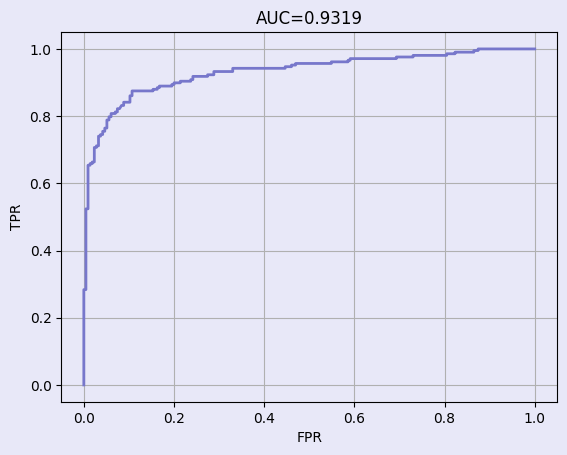

None
[0.94463054 3.65737241 0.04487479]
AUC: 0.8896103896103895
[0.938405   5.07993108 0.05246592]
AUC: 0.9670588235294117
[0.93465116 0.70881325 0.05516302]
AUC: 0.9294117647058824
[0.93747166 0.76091721 0.08422983]
AUC: 0.9069264069264068
[0.93578812 4.95440892 0.04581721]
AUC: 0.9105882352941177
[0.94318111 0.60741528 0.05935901]
AUC: 0.9927884615384615


In [27]:

def plot_roc(fpr, tpr):
    # ROC AUC
    # fpr, tpr, thresholds = metrics.roc_curve(validY, validProb, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print("ROC_AUC :", roc_auc)

    fig = plt.figure()
    fig.patch.set_facecolor('#e8e8f8')
    plt.plot(fpr, tpr, 'k-', lw=2, color='#7777cb')
    plt.title('AUC={:.4f}'.format(roc_auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.gca().set_facecolor('#e8e8f8')

    plt.grid(True)
    plt.show()

print(plot_roc(fpr, tpr))